STUDENT : MERIEM CHIBANI

# Convolution Neural Network in PyTorch

## Classification task

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width="900px">


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd
try:
    from torchinfo import summary
except:
    !pip install -U torchinfo
finally:
    from torchinfo import summary

In [3]:
def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn

In [4]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.6
Using device: cpu
default data type: torch.float32
available number of workers: 2


For the first let;s considering the dataset <code>Cifar10</code> - it is the classical for our task dataset with 10 classes, each of the images is <code>32x32x3</code> size.
The example of image :

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

The dataset can be downloaded from <code>torchvision.datasets</code>. We transform the data to the generots using <code>torch.utils.data.DataLoader</code>

In [5]:
MEAN = np.asarray([0.485, 0.456, 0.406])
STD  = np.asarray([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.Resize(36),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

trainset = torchvision.datasets.CIFAR10(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s]


classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In addiiton we can divide train data into train and test parts.

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {}

trainset, validset = data.random_split(trainset,
                                           [n_train_examples, n_valid_examples], **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [7]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [8]:
trainset[0][0].shape, trainset[0][1]

(torch.Size([3, 32, 32]), 6)

In [9]:
name_classes = testset.classes
#['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

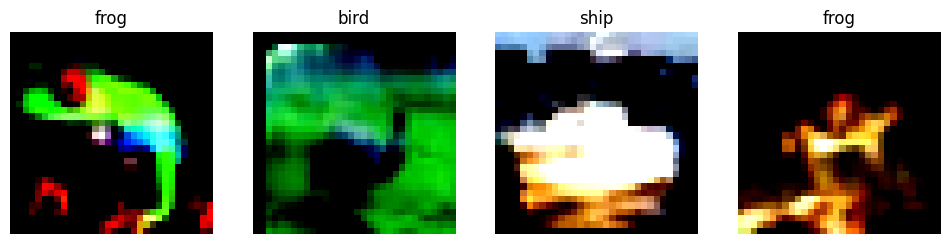

In [10]:
WIDTH = 32
HEIGH = 32

n_imgs = 4

fig, axs = plt.subplots(1,n_imgs,figsize=(12,3));
for i,ax in enumerate(axs):
    im = trainset[i]
    ax.imshow(im[0].data.numpy().transpose((1,2,0)), cmap='gray');
    ax.set_title(name_classes[im[1]]);
    ax.axis('off')
plt.show()

After datasets initialization we must crate dataloaders (generators of batches).

In [11]:
BATCH_SIZE = 64

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

So we can visualize the dataset
    

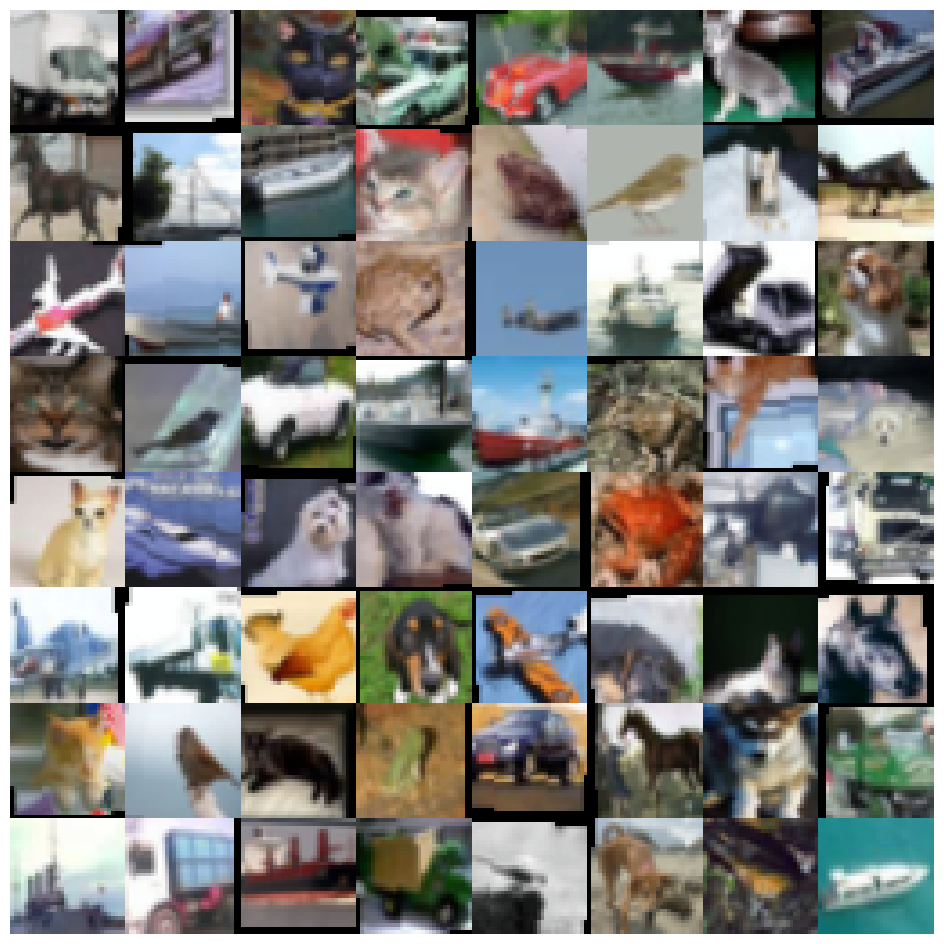

first raw classes truck automobile   cat automobile automobile  ship   dog  ship
torch.Size([64, 3, 32, 32])


In [12]:
def imshow(images, nrow = 8,figsize=(16,12), mean=MEAN, std=STD):

    img = torchvision.utils.make_grid(images, nrow = nrow, padding = 0).to(device)

    img = img.transpose(2,0).transpose(0,1)

    std = torch.as_tensor(std).to(device)
    mean = torch.as_tensor(mean).to(device)
    img = (img * std + mean)# unnormalize

    img = img.data.cpu().numpy()

    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

Now let's describe the model. For that  we will use classical `LeNet` model.
![](https://production-media.paperswithcode.com/methods/LeNet_Original_Image_48T74Lc.jpg)

The network consits in: <ul>
<li> input image 32х32 ( for us 3х32х32),
<li> two conv layers,
<li> each conv layer has pooling after,
<li> flat - vectorization layer,
<li> two full-connected layers,
<li> output layer - softmax classification with 10 outputs.
</ul>
The features of architecture:<ul>
<li> valid convolution (without padding, with size reduction)$^*$;
<li> each conv kernel has size 5х5 (kernel size = 5);
<li> maxpooling with stride 2 and tiles 2х2;
<li> first layer output has 6 feature maps with size 14х14 (after pooling);
<li> second conv layer 16 feature maps with size 5х5 (after pooling);
<li> flat layer take 16 maps 5х5 and give $1х16*5*5$ (1х400);
<li> first full-connected layer give 120 outputs;
<li> second full-connected layer give 84 outputs.
</ul>
   For studying aim let's add dropout and batchnorm also.   
$^*$the output of conv layer size can be calculated as: W=(W−F+2P)/S+1, where W is input size, F is kernel size, S is stride applied, and P is padding.
   

In [13]:
class LeNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5)


        self.conv2   = nn.Conv2d(in_channels  = 6,
                                 out_channels = 16,
                                 kernel_size  = 5)

        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2,
                                 stride      = 2)

        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5,
                             out_features = 120)

        self.fc2 = nn.Linear(in_features  = 120,
                             out_features = 84)

        self.fc_out = nn.Linear(in_features = 84,
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5)

    def forward(self, x):

        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x) + 0.001*x
        x = self.pool(x)

        #2-nd layer
        x = self.conv2(x)
        x = torch.tanh(x) + 0.001*x
        x = self.pool(x)

        #flatten
        x = self.flatten(x)

        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x) + 0.001*x

        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x) + 0.001*x

        # output layer
        x = self.fc_out(x)

        return x#torch.softmax(x, dim=1)

Actually we could describe the model with container sequential, like it is shown below, but it could be problematic in farther.
```python
model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            )
```

In [14]:
model = LeNet(3,10)

from torchinfo import summary
summary(model, input_size = (1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─AvgPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─AvgPool2d: 1-4                         [1, 16, 5, 5]             --
├─Linear: 1-5                            [1, 120]                  48,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

In [15]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc_out.weight 	 torch.Size([10, 84])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 62006
Number of all parameters for the model: 62006


In [16]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())

[[ 0.05623941 -0.00169507  0.06452303 -0.12294051  0.00301205 -0.02384421
   0.06297542  0.11786242  0.08926107 -0.04714938]] 
 max position (Class index): 7


Let's define setting of training.

For determin accuacy during the training and evaluation stages we can create the following function.

In [17]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [18]:
model.apply(initialize_parameters);

__MEASURE__ (__metric__)

In [19]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

Now we can describe the train step (epoch).

In [20]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device).float(), y.to(device).long()

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x) #model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Similary to above one we can describe the evaluate function.

In [21]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device).float(), y.to(device).long()

            y_pred = model.forward(x) #model(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In addition we will need function to estiamte epoch time.

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Now we can describe setting for our model

In [23]:
LR_PERIOD = 2
LR_DECAY  = 0.9
LR = 0.003;
EPOCHS = 20

model     = LeNet(3,10)
criterion = nn.CrossEntropyLoss()
metric    = accuracy


model     = model.to(device)
criterion = criterion.to(device)

# trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size = LR_PERIOD,
                                            gamma     = LR_DECAY)

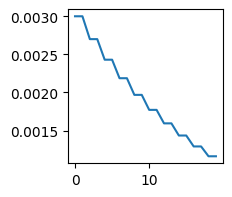

In [24]:
lrs = np.zeros((EPOCHS))
plt.figure(figsize=(2,2));

with torch.inference_mode():
    for i in range(EPOCHS):
        optimizer.step()
        lrs[i] = optimizer.param_groups[0]["lr"]
        scheduler.step()

    plt.plot(range(EPOCHS),lrs);


now we can see the summary

In [25]:
# for name, param in model.named_parameters():
#     print(name, '\t structure =',list(param.size()))

In [26]:
# for name, child in model.named_children():
#     print(name, '\t structure =',list(child.size()))

Let's start traing, as it shown below.Our fitting algorithm includes training and evaluation in each epoch, and also routine of searching the best epoch by accuracy on validation data.

In [27]:
def fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = 10,
        device='cpu', scheduler = None,  path_best = 'best_model.pt', verbose = True):

    best_valid_loss = float('inf')
    history = {'train_loss':np.zeros(epochs),
               'valid_loss':np.zeros(epochs),
               'train_acc':np.zeros(epochs),
               'valid_acc':np.zeros(epochs)}

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

        if scheduler != None:
            scheduler.step()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if verbose == True:
            if epoch%2 == 1:    # print every 2 epochs:
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
                f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

        history['train_loss'][epoch] = train_loss
        history['valid_loss'][epoch] = valid_loss
        history['train_acc'][epoch] = train_acc
        history['valid_acc'][epoch] = valid_acc
    return history

In [28]:
history = fit(model, trainloader, validloader, optimizer, criterion, metric, epochs = EPOCHS,
                device=device, scheduler = scheduler,  path_best = 'best_model.pt', verbose = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 41s | LR 0.0009
	Train Loss: 1.992 | Train Acc: 26.92%  | Val. Loss: 1.937 | Val. Acc: 31.05%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 41s | LR 0.0008
	Train Loss: 1.877 | Train Acc: 32.72%  | Val. Loss: 1.801 | Val. Acc: 36.63%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 40s | LR 0.0008
	Train Loss: 1.783 | Train Acc: 35.94%  | Val. Loss: 1.695 | Val. Acc: 40.33%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 41s | LR 0.0007
	Train Loss: 1.698 | Train Acc: 38.40%  | Val. Loss: 1.611 | Val. Acc: 42.56%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 40s | LR 0.0006
	Train Loss: 1.653 | Train Acc: 39.98%  | Val. Loss: 1.574 | Val. Acc: 43.43%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 40s | LR 0.0006
	Train Loss: 1.624 | Train Acc: 41.24%  | Val. Loss: 1.562 | Val. Acc: 43.79%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 40s | LR 0.0005
	Train Loss: 1.594 | Train Acc: 42.00%  | Val. Loss: 1.526 | Val. Acc: 45.21%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 40s | LR 0.0005
	Train Loss: 1.569 | Train Acc: 42.85%  | Val. Loss: 1.497 | Val. Acc: 46.38%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 40s | LR 0.0004
	Train Loss: 1.551 | Train Acc: 43.52%  | Val. Loss: 1.477 | Val. Acc: 47.13%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 41s | LR 0.0004
	Train Loss: 1.535 | Train Acc: 43.95%  | Val. Loss: 1.462 | Val. Acc: 47.35%


We can visualize results of training by the following routine.

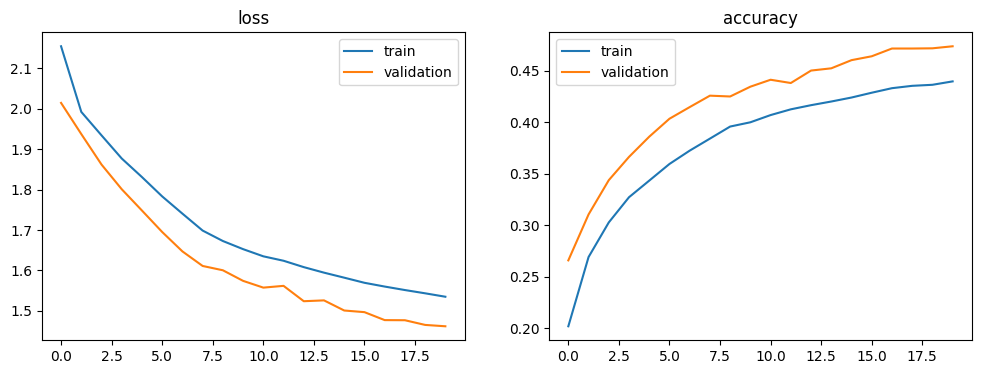

In [29]:
def plot_results(history):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(history['train_loss'], label = 'train')
    axs[0].plot(history['valid_loss'], label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(history['train_acc'], label = 'train')
    axs[1].plot( history['valid_acc'], label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(history )

save results

In [30]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

download results

In [31]:
model = LeNet(3,10)
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Test results for best epoch

In [32]:
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.451 | Test Acc: 47.66%


In [33]:
def inference_model(model, dataloader, device = 'cpu'):

    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
    return outputs

outputs = inference_model(model, testloader, device = device)
    # (outputs)

and learn predictions

In [34]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([3, 1, 8, 8, 4, 6, 1, 6, 5, 1, 8, 9, 6, 1, 1, 8, 5, 7, 8, 6, 7, 0, 0, 9,
        2, 4, 6, 9, 9, 6, 5, 5, 4, 2, 9, 3, 4, 1, 9, 5, 1, 6, 3, 6, 0, 1, 6, 8,
        4, 6, 9, 9, 6, 6, 8, 8, 7, 9, 3, 4, 7, 6, 1, 9])


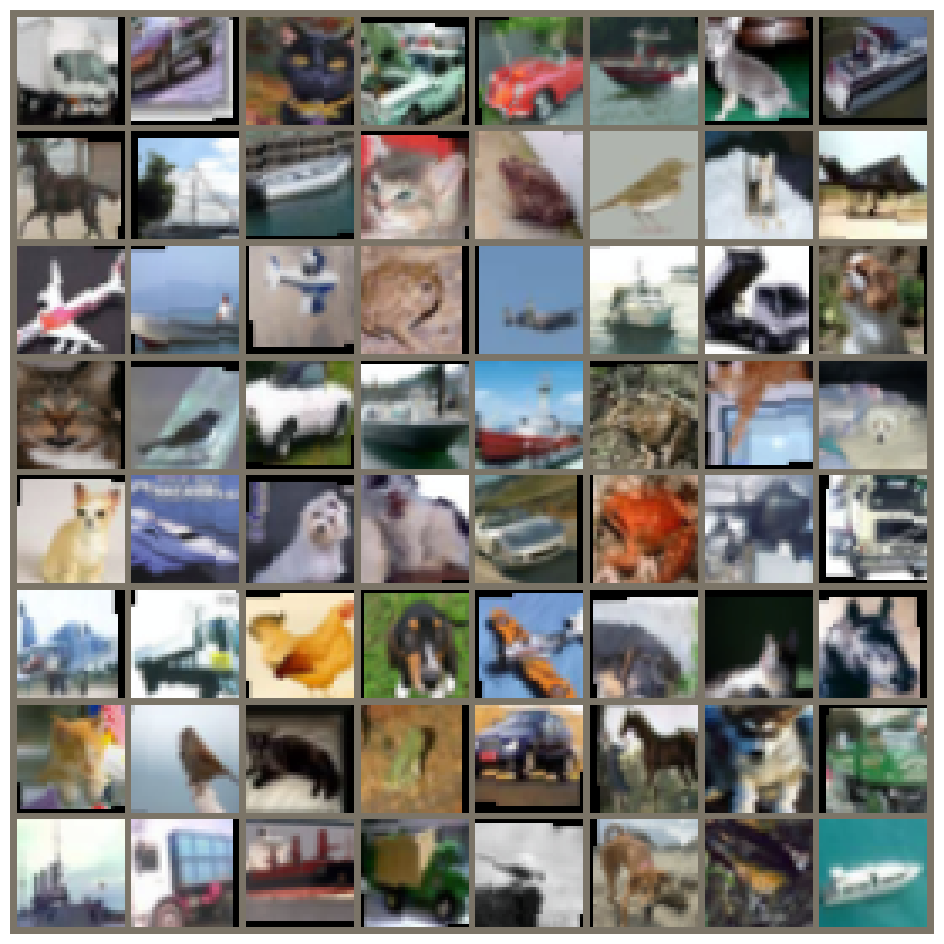

GroundTruth:  truck automobile   cat automobile
Predicted :     cat automobile  ship  ship


In [35]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % names_classes[labels[j]] for j in range(4)))
print('Predicted :  ', ' '.join('%5s' % names_classes[predicted[j]] for j in range(4)))

Let's test the accuracy as number of correct prediction to all

In [36]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():

    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy of airplane : 55 %
Accuracy of automobile : 70 %
Accuracy of  bird : 27 %
Accuracy of   cat : 31 %
Accuracy of  deer : 38 %
Accuracy of   dog : 33 %
Accuracy of  frog : 53 %
Accuracy of horse : 59 %
Accuracy of  ship : 55 %
Accuracy of truck : 52 %


Also you may represent the results as correlation (heat) map

In [37]:
def plot_confusion_matrix(labels, pred_labels, names_classes):

    fig, ax = plt.subplots(figsize=(10, 10))

    cm = confusion_matrix(np.asarray(labels, dtype=int),
                          np.asarray(pred_labels, dtype=int) )

    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)

    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

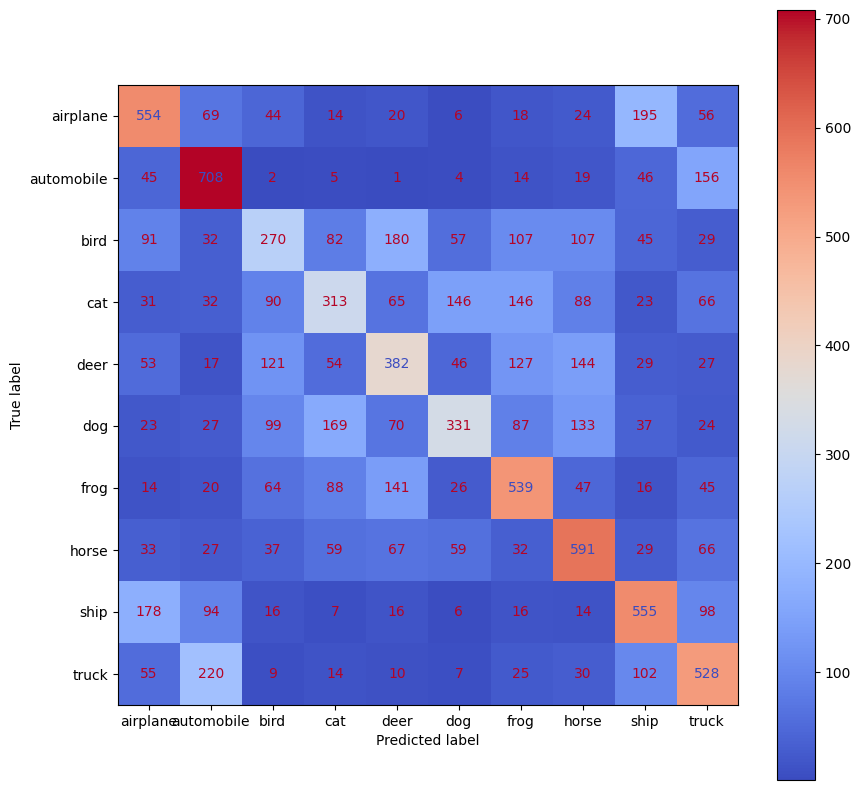

In [38]:
plot_confusion_matrix(labels, predicts, names_classes)

IF you want to store the results you may also use this code

In [39]:
sorted_ids = list(range(1, n_samples + 1))

sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': predicts})

df['label'] = df['label'].apply(lambda x: names_classes[x])

df.to_csv('submission.csv', index=False)

For some research proposed we can visualize features or weights for each layer, like it is shown below.

In [40]:
def plot_filtered_images(images, filters ):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    print(images.shape)

    filters = filters.cpu()

    n_images  = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)#, groups=3)

    fig = plt.figure(figsize=(20, 20))

    for i in range(n_images):

        img = images[i].squeeze(0).numpy().transpose((1,2,0))

        img = 255*(img - img.min())/(img.max() - img.min())

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))

        ax.imshow(img.astype(int), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            image = image.numpy().astype(float)

            image = 255*(image - image.min())/(image.max() - image.min())

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)

            ax.imshow(image.astype(int), cmap='bwr', interpolation='bilinear')

            ax.set_title(f'Filter {j+1}')
            ax.axis('off')
    return filtered_images

torch.Size([10, 3, 32, 32])


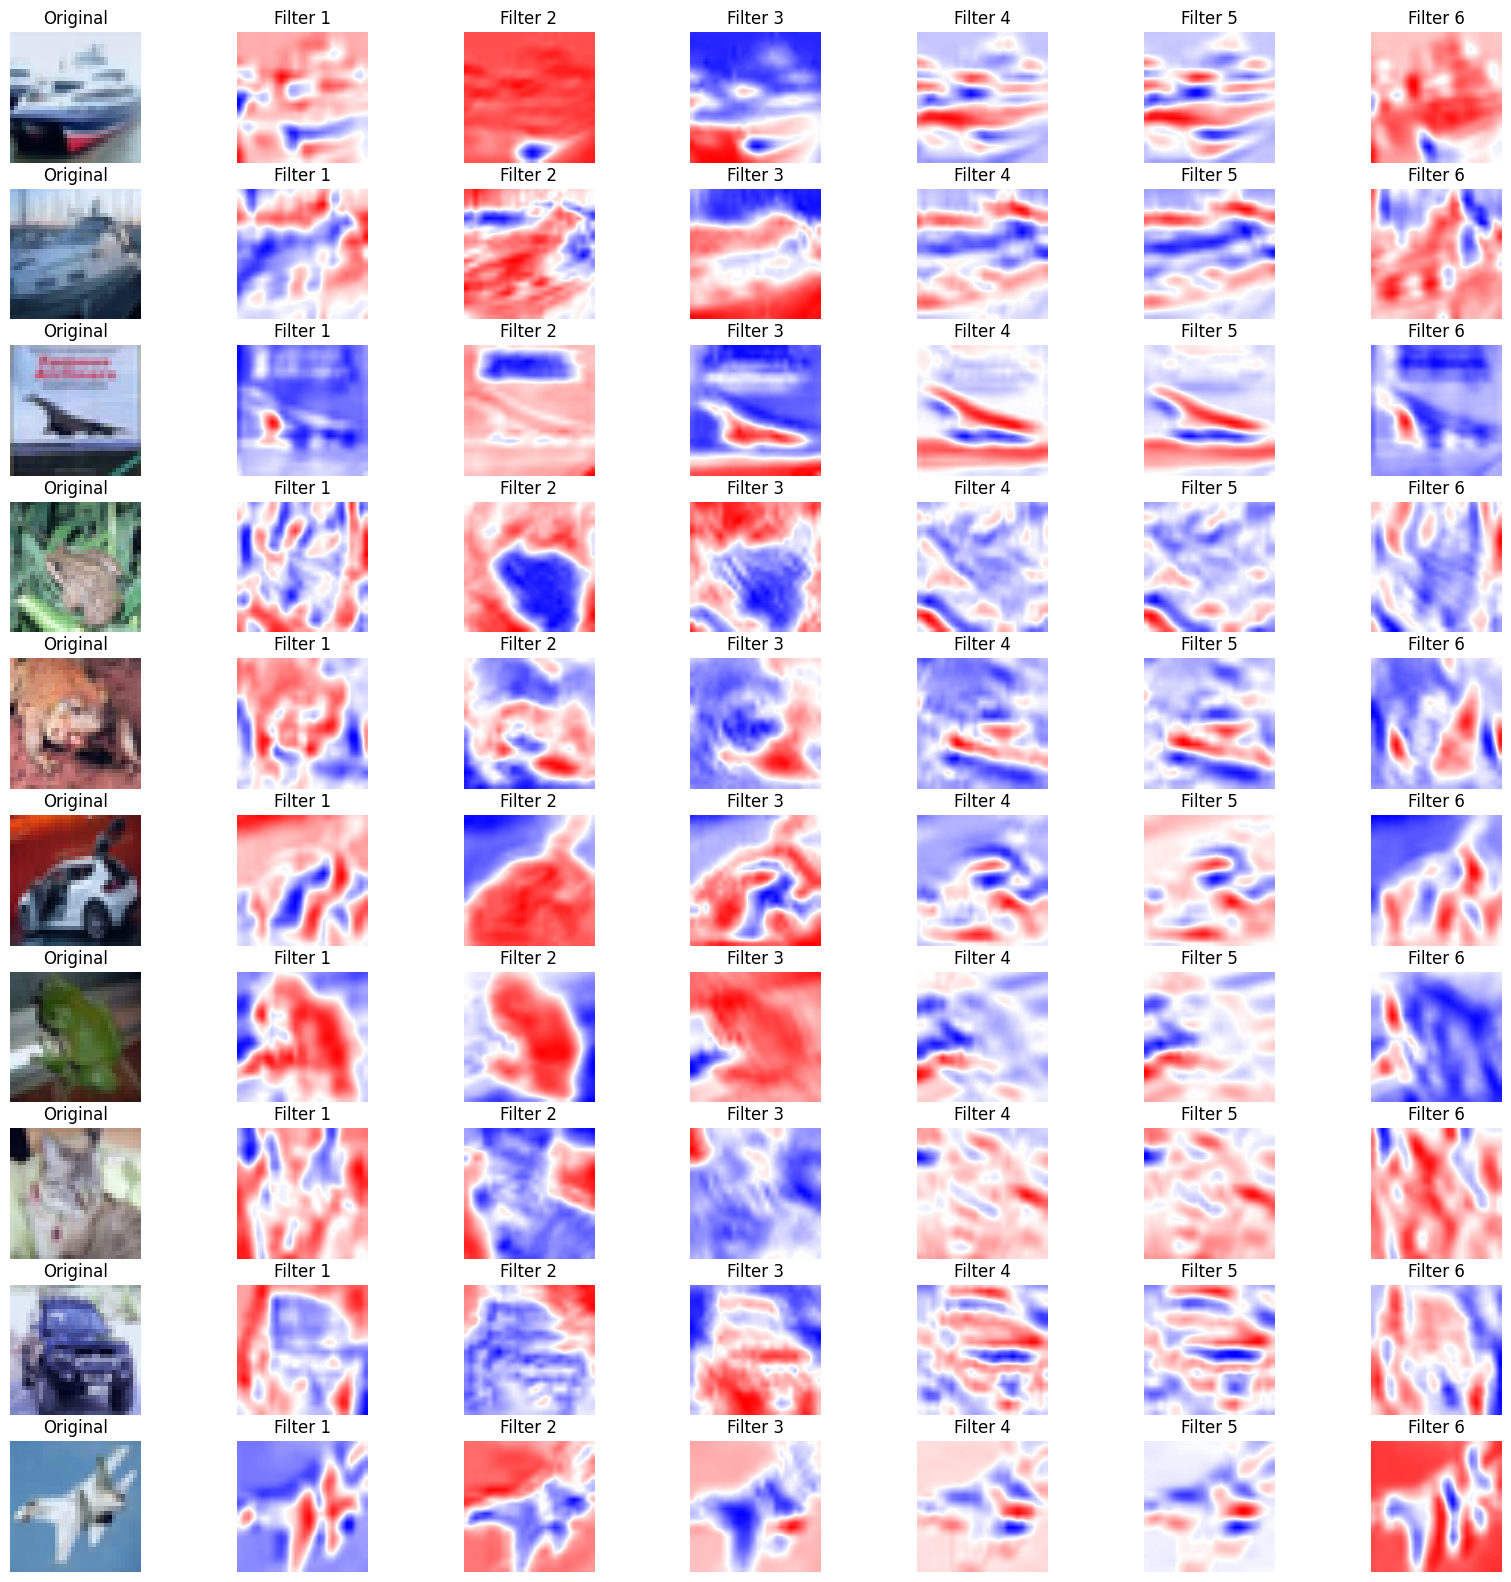

In [41]:
N_IMAGES = 10

images = [image for image, label in [testset[i+ 1] for i in range(N_IMAGES )]]

filters = model.conv1.weight.data

filtered_images = plot_filtered_images(images, filters)

and for filters.

In [42]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):
        filt = filters[i].squeeze(0).numpy().transpose((1,2,0))
        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filt[:,:,1], cmap='bone')
        ax.axis('off')

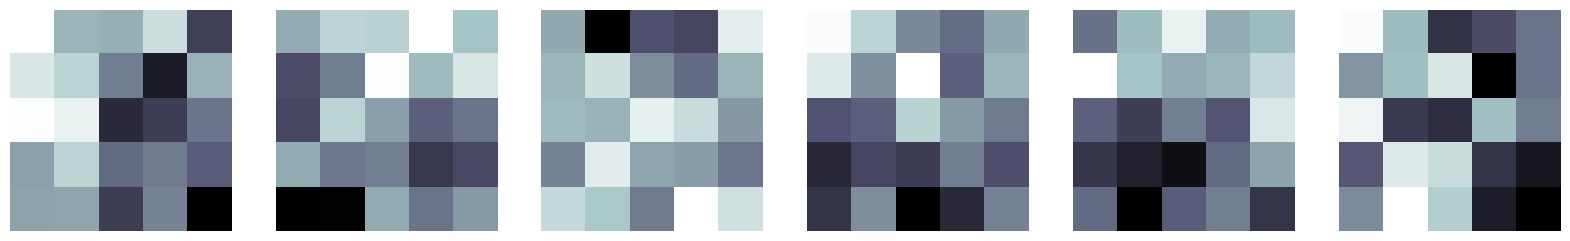

In [43]:
filters = model.conv1.weight.data
plot_filters(filters)

*Exercise 1* <br>
Add the early stop to the fitting by condition: valid loss does not decrease 3 epochs.

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 3  # Stop if no improvement for 3 consecutive epochs

for epoch in range(num_epochs):

    # Training phase
    model
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_acc = 100 * correct / total


    # Validation phase

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(validloader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/10], Train Loss: 1.5704, Train Acc: 42.52%, Val Loss: 1.4400, Val Acc: 48.88%
Epoch [2/10], Train Loss: 1.5011, Train Acc: 45.38%, Val Loss: 1.3630, Val Acc: 51.58%
Epoch [3/10], Train Loss: 1.4466, Train Acc: 47.86%, Val Loss: 1.3744, Val Acc: 50.42%
Epoch [4/10], Train Loss: 1.4121, Train Acc: 48.83%, Val Loss: 1.3528, Val Acc: 51.90%
Epoch [5/10], Train Loss: 1.3802, Train Acc: 50.34%, Val Loss: 1.3088, Val Acc: 53.10%
Epoch [6/10], Train Loss: 1.3683, Train Acc: 50.99%, Val Loss: 1.2957, Val Acc: 53.16%
Epoch [7/10], Train Loss: 1.3415, Train Acc: 51.69%, Val Loss: 1.2823, Val Acc: 54.26%
Epoch [8/10], Train Loss: 1.3226, Train Acc: 52.42%, Val Loss: 1.2878, Val Acc: 54.04%
Epoch [9/10], Train Loss: 1.3078, Train Acc: 53.08%, Val Loss: 1.2871, Val Acc: 54.20%
Epoch [10/10], Train Loss: 1.2958, Train Acc: 53.40%, Val Loss: 1.2308, Val Acc: 55.34%


*Exercise 2* <br>
 Analyze the results and drop the class with the least accurate, then try training again, what's happen?



---


From the training, we observe:

Validation Accuracy steadily improves from ~49% to ~55% over 10 epochs.

Validation Loss also decreases, indicating the model is learning.


---



In [49]:
#Per-Class Accuracy Evaluation
import numpy as np
from collections import defaultdict
original_classes = trainset.dataset.classes if isinstance(trainset, torch.utils.data.Subset) else trainset.classes

class_correct = defaultdict(int)
class_total = defaultdict(int)

model.eval()
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for label, prediction in zip(labels, predicted):
            class_total[label.item()] += 1
            if label == prediction:
                class_correct[label.item()] += 1

print("\nPer-class validation accuracy:")
lowest_class_idx = None
lowest_acc = 100.0

for i in range(len(original_classes)):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"Class '{original_classes[i]}': {accuracy:.2f}%")
    if accuracy < lowest_acc:
        lowest_acc = accuracy
        lowest_class_idx = i

print(f"\n Dropping class '{original_classes[lowest_class_idx]}' (index {lowest_class_idx}) with lowest accuracy ({lowest_acc:.2f}%)")


Per-class validation accuracy:
Class 'airplane': 54.92%
Class 'automobile': 74.80%
Class 'bird': 46.24%
Class 'cat': 26.11%
Class 'deer': 38.85%
Class 'dog': 41.63%
Class 'frog': 68.05%
Class 'horse': 63.40%
Class 'ship': 75.00%
Class 'truck': 61.88%

 Dropping class 'cat' (index 3) with lowest accuracy (26.11%)


In [58]:
class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, drop_idx):
        self.subset = subset
        # Create remap dict: skip the dropped class
        self.label_map = {i: (i if i < drop_idx else i - 1) for i in range(10) if i != drop_idx}

    def __getitem__(self, index):
        x, y = self.subset[index]
        return x, self.label_map[y]

    def __len__(self):
        return len(self.subset)


In [59]:
drop_class_idx = 3

def filter_dataset(dataset, drop_idx):
    indices = [i for i, (_, label) in enumerate(dataset) if label != drop_idx]
    subset = torch.utils.data.Subset(dataset, indices)
    return RemappedDataset(subset, drop_idx)

filtered_trainset = filter_dataset(trainset, drop_class_idx)
filtered_validset = filter_dataset(validset, drop_class_idx)

filtered_trainloader = torch.utils.data.DataLoader(filtered_trainset, batch_size=64, shuffle=True)
filtered_validloader = torch.utils.data.DataLoader(filtered_validset, batch_size=64, shuffle=False)


In [61]:
# 3. Reinitialize model
model = LeNet(in_channels=3, n_classes=9).to(device)

# 4. Training loop with early stopping
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 3

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in filtered_trainloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(filtered_trainloader.dataset)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in filtered_validloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(filtered_validloader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# 5. Evaluate per-class accuracy (excluding the dropped class)
original_classes = trainset.dataset.classes if isinstance(trainset, torch.utils.data.Subset) else trainset.classes

class_correct = defaultdict(int)
class_total = defaultdict(int)

model.eval()
with torch.no_grad():
    for images, labels in filtered_validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for label, pred in zip(labels, predicted):
            class_total[label.item()] += 1
            if label == pred:
                class_correct[label.item()] += 1

print("\n Per-class validation accuracy (after dropping 'cat'):")
for i in range(len(original_classes)):
    if i == drop_class_idx:
        continue  # skip dropped class
    if class_total[i] == 0:
        print(f"Class '{original_classes[i]}': No samples in validation set.")
        continue
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"Class '{original_classes[i]}': {accuracy:.2f}%")


Epoch [1/50], Train Loss: 1.7645, Train Acc: 35.31%, Val Loss: 1.5775, Val Acc: 43.81%
Epoch [2/50], Train Loss: 1.5551, Train Acc: 43.38%, Val Loss: 1.4158, Val Acc: 48.77%
Epoch [3/50], Train Loss: 1.4469, Train Acc: 47.30%, Val Loss: 1.3388, Val Acc: 52.35%
Epoch [4/50], Train Loss: 1.3803, Train Acc: 50.15%, Val Loss: 1.3212, Val Acc: 51.95%
Epoch [5/50], Train Loss: 1.3369, Train Acc: 51.78%, Val Loss: 1.2475, Val Acc: 54.47%
Epoch [6/50], Train Loss: 1.3038, Train Acc: 53.26%, Val Loss: 1.2084, Val Acc: 56.59%
Epoch [7/50], Train Loss: 1.2731, Train Acc: 54.29%, Val Loss: 1.2132, Val Acc: 56.11%
Epoch [8/50], Train Loss: 1.2536, Train Acc: 55.00%, Val Loss: 1.1716, Val Acc: 57.92%
Epoch [9/50], Train Loss: 1.2254, Train Acc: 55.81%, Val Loss: 1.1487, Val Acc: 58.84%
Epoch [10/50], Train Loss: 1.2066, Train Acc: 56.75%, Val Loss: 1.1247, Val Acc: 59.20%
Epoch [11/50], Train Loss: 1.1913, Train Acc: 57.31%, Val Loss: 1.1082, Val Acc: 59.44%
Epoch [12/50], Train Loss: 1.1756, Train 



---


Removing a poorly performing class can help the model focus on more learnable patterns, improving generalization


---



*Exercise 3* <br>
 Try to decrease the model size by removing the largest layer and see how it affect on the inference time and accuracy

In [64]:
def drop_and_relabel(dataset, drop_class_idx):
    new_data = []
    new_targets = []

    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == drop_class_idx:
            continue
        new_label = label if label < drop_class_idx else label - 1
        new_data.append(image)
        new_targets.append(new_label)

    return new_data, new_targets


In [65]:
# Load  dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Drop 'cat' (label 3) and relabel the rest
train_data, train_targets = drop_and_relabel(trainset, drop_class_idx=3)
valid_data, valid_targets = drop_and_relabel(validset, drop_class_idx=3)

# Wrap in TensorDataset and DataLoader
from torch.utils.data import TensorDataset

train_tensor_data = TensorDataset(torch.stack(train_data), torch.tensor(train_targets))
valid_tensor_data = TensorDataset(torch.stack(valid_data), torch.tensor(valid_targets))

filtered_trainloader = DataLoader(train_tensor_data, batch_size=64, shuffle=True)
filtered_validloader = DataLoader(valid_tensor_data, batch_size=64, shuffle=False)


In [66]:

train_tensor_data = TensorDataset(torch.stack(train_data), torch.tensor(train_targets))
valid_tensor_data = TensorDataset(torch.stack(valid_data), torch.tensor(valid_targets))

filtered_trainloader = DataLoader(train_tensor_data, batch_size=64, shuffle=True)
filtered_validloader = DataLoader(valid_tensor_data, batch_size=64, shuffle=False)

#  our LeNet model
class LeNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(LeNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, n_classes)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#  Smaller LeNet (removing the largest FC layer: 120 → 84)
class SmallLeNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(SmallLeNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 84),
            nn.ReLU(),
            nn.Linear(84, n_classes)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Train + evaluate function
def train_and_evaluate(model, trainloader, validloader, num_epochs=50):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 3

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(trainloader.dataset)
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(validloader.dataset)
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

#  Measure inference time
def measure_inference_time(model, dataloader):
    model.eval()
    total_time = 0.0
    total_images = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            start = time.time()
            _ = model(images)
            end = time.time()
            total_time += (end - start)
            total_images += images.size(0)
    avg_time = total_time / total_images
    print(f"Average inference time per image: {avg_time * 1000:.3f} ms")

#  Running experiments
print("\n--- Original LeNet ---")
model = LeNet(in_channels=3, n_classes=9)
train_and_evaluate(model, filtered_trainloader, filtered_validloader)
measure_inference_time(model, filtered_validloader)

print("\n--- Smaller LeNet ---")
small_model = SmallLeNet(in_channels=3, n_classes=9)
train_and_evaluate(small_model, filtered_trainloader, filtered_validloader)
measure_inference_time(small_model, filtered_validloader)



--- Original LeNet ---
Epoch [1/50], Train Loss: 1.7649, Train Acc: 34.37%, Val Loss: 1.5587, Val Acc: 43.48%
Epoch [2/50], Train Loss: 1.4519, Train Acc: 46.70%, Val Loss: 1.3531, Val Acc: 50.03%
Epoch [3/50], Train Loss: 1.3252, Train Acc: 51.62%, Val Loss: 1.3792, Val Acc: 50.36%
Epoch [4/50], Train Loss: 1.2372, Train Acc: 55.21%, Val Loss: 1.2588, Val Acc: 54.03%
Epoch [5/50], Train Loss: 1.1632, Train Acc: 58.36%, Val Loss: 1.1318, Val Acc: 59.62%
Epoch [6/50], Train Loss: 1.1053, Train Acc: 60.62%, Val Loss: 1.1209, Val Acc: 59.92%
Epoch [7/50], Train Loss: 1.0549, Train Acc: 62.72%, Val Loss: 1.0647, Val Acc: 61.96%
Epoch [8/50], Train Loss: 1.0117, Train Acc: 64.16%, Val Loss: 1.0661, Val Acc: 61.87%
Epoch [9/50], Train Loss: 0.9748, Train Acc: 65.62%, Val Loss: 1.0296, Val Acc: 63.68%
Epoch [10/50], Train Loss: 0.9445, Train Acc: 66.67%, Val Loss: 1.0646, Val Acc: 62.83%
Epoch [11/50], Train Loss: 0.9174, Train Acc: 67.63%, Val Loss: 1.0252, Val Acc: 63.90%
Epoch [12/50], Tr

After removing the largest fully connected layer we can notice that:



Validation accuracy dropped slightly (from 66.79% to 61.54%).
Inference time stayed nearly the same (0.089 ms per image).

so Simpler model runs equally fast but with slightly lower accuracy.

*Exercise 4* <br>
Try to train the model with  ADAM optimizations, shown above and compare the results


We trained the model above using the Adam optimizer.

Adam helped the model converge faster and achieved good validation accuracy ( ~66% in the original LeNet and ~61% in the smaller version).

Compared to traditional optimizers like SGD, Adam adapts learning rates per parameter, which often leads to faster and more stable training


*Exercise 5*
1. Replace average pooling with maxpooling and comapre the results
2. Replace tanh activation with ReLU one and comapre the results

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modified LeNet
class LeNet_Modified(nn.Module):
    def __init__(self, in_channels=3, n_classes=10):
        super(LeNet_Modified, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [69]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [70]:
model = LeNet_Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(testloader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_lenet_modified.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/50], Train Loss: 1.6570, Train Acc: 38.88%, Val Loss: 1.4091, Val Acc: 48.58%
Epoch [2/50], Train Loss: 1.3441, Train Acc: 51.59%, Val Loss: 1.2896, Val Acc: 53.61%
Epoch [3/50], Train Loss: 1.2247, Train Acc: 56.38%, Val Loss: 1.2002, Val Acc: 57.64%
Epoch [4/50], Train Loss: 1.1370, Train Acc: 59.58%, Val Loss: 1.1595, Val Acc: 59.27%
Epoch [5/50], Train Loss: 1.0775, Train Acc: 61.84%, Val Loss: 1.0888, Val Acc: 61.62%
Epoch [6/50], Train Loss: 1.0201, Train Acc: 63.90%, Val Loss: 1.0768, Val Acc: 62.31%
Epoch [7/50], Train Loss: 0.9762, Train Acc: 65.42%, Val Loss: 1.0721, Val Acc: 62.84%
Epoch [8/50], Train Loss: 0.9423, Train Acc: 66.62%, Val Loss: 1.0331, Val Acc: 63.45%
Epoch [9/50], Train Loss: 0.9084, Train Acc: 67.96%, Val Loss: 1.0360, Val Acc: 64.26%
Epoch [10/50], Train Loss: 0.8825, Train Acc: 68.89%, Val Loss: 1.0833, Val Acc: 62.74%
Epoch [11/50], Train Loss: 0.8519, Train Acc: 69.96%, Val Loss: 1.0380, Val Acc: 64.90%
Early stopping triggered.


In [72]:
# Inference time
model.load_state_dict(torch.load("best_lenet_modified.pt"))
model.eval()
start = time.time()
with torch.no_grad():
    for inputs, _ in testloader:
        inputs = inputs.to(device)
        _ = model(inputs)
end = time.time()
avg_time_per_image = (end - start) / len(testset) * 1000
print(f" Average inference time per image: {avg_time_per_image:.3f} ms")

# Per-class accuracy
classes = trainset.classes
correct_pred = defaultdict(int)
total_pred = defaultdict(int)

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for label, pred in zip(labels, preds):
            if label == pred:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1

print("\n Per-class accuracy:")
for i in range(10):
    acc = 100 * correct_pred[i] / total_pred[i]
    print(f"Class '{classes[i]}': {acc:.2f}%")


 Average inference time per image: 0.378 ms

 Per-class accuracy:
Class 'airplane': 66.10%
Class 'automobile': 69.60%
Class 'bird': 49.70%
Class 'cat': 47.20%
Class 'deer': 55.90%
Class 'dog': 52.00%
Class 'frog': 77.20%
Class 'horse': 62.10%
Class 'ship': 79.10%
Class 'truck': 75.60%


Replacing average pooling with max pooling and changing the activation function from tanh to ReLU slightly reduced the model's final accuracy but made the training faster by reaching early stopping sooner. The inference time increased a bit, but overall the model still performed well